# Avis Restau : improve the AI product of your start-up

## Context

"Avis Restau" is a start-up who's goal is to connect restaurants and customers. Customers will be able to post photos and reviews of the restaurants they have visited.

The goal here is to identify topics of bad customer reviews and to label photos as indoor or outdoor , food or drink, ...


## Load project modules

The helpers functions and project specific code will be placed in `../src/`.

We will use the [Python](https://www.python.org/about/gettingstarted/) programming language, and present here the code and results in this [Notebook JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html) file.

We will use the usual libraries for data exploration, modeling and visualisation :

-   [NumPy](https://numpy.org/doc/stable/user/quickstart.html) and [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) : for maths (stats, algebra, ...) and large data manipulation
-   [scikit-learn](https://scikit-learn.org/stable/getting_started.html) : for machine learning models training and evaluation
-   [Plotly](https://plotly.com/python/getting-started/) : for interactive data visualization

We will also use libraries specific to the goals of this project :

-   NLP Natural Language Processing
    -   [NLTK](https://www.nltk.org/) and [Spacy](https://spacy.io/api) : for text processing
    -   [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html) and [pyLDAvis](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) : for topic modelling and visualisation
-   CV Computer Visio
    -   [scikit-image](https://scikit-image.org/docs/stable/overview.html) and [OpenCV](https://docs.opencv.org/4.x/index.html) : for image processing
    -   [Keras](https://keras.io/getting_started/) : for neural network models training and evaluation


In [1]:
# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


# Set up logging
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)


# System modules
import random


# ML modules
import pandas as pd
import numpy as np


# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Sample data for development
TEXT_SAMPLE_SIZE = 5 * 1000  # <= 0 for all
PHOTO_SAMPLE_SIZE = 5 * 1000  # <= 0 for all


import plotly.io as pio

pio.renderers.default = "notebook"

## Academic dataset

We will use also use the Academic dataset provided by Yelp (https://www.yelp.com/dataset) composed of 8,635,403 reviews, 160,585 businesses and 200,000 pictures from 8 metropolitan areas.

We are only going to use the reviews and photos data. Since the dataset is huge, we are going to sample a small subset of the data.


### Load the dataset from JSON


In [2]:
# Load data
photos_df = pd.DataFrame()
with pd.read_json(
    "../data/raw/academic/photos.json",
    chunksize=500 * 1000,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_df = photos_df.append(chunk)
        logger.info(f"Loaded {len(photos_df)} photos")
logger.info(f">>> OK : {len(photos_df)} photos loaded from JSON file.")

# Reduce memory usage
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)

### Exploratory Data Analysis

We will just display here a few statistics about the DataFrame.


In [3]:
# Sample data
if PHOTO_SAMPLE_SIZE > 0:
    sampled_photos_df = pd.DataFrame()
    for label in photos_df.label.unique():
        sampled_photos_df = sampled_photos_df.append(
            photos_df[photos_df.label == label].sample(
                int(PHOTO_SAMPLE_SIZE / (len(photos_df.label.unique()))),
                random_state=42,
            )
        )
    photos_df = sampled_photos_df

photos_df.describe(include="all")

photo_id             business_id caption  label
count                     5000                    5000    5000   5000
unique                    5000                    4167    2506      5
top     z6-4XQmfKuBuQ0GLVtJerA  ZpwuFRTsbkssDMeSGWQGRw          drink
freq                         1                       9    2188   1000

In [4]:
# Plot labels
px.histogram(
    photos_df,
    x="label",
    color="label",
    histnorm="probability",
    title=f"Photos distribution by label (N={len(photos_df)})",
)

Labels are uniformly distributed among the 5 classes : "drink", "food", "indoor", "outdoor" and "menu".

## Computer vision

In this section, we are going to try and predict the label of the photos.

To achieve this, we need to :

-   extract visual features from our dataset : 
    -   colors : RGB, HSV and LAB histograms of patches of the image
    -   shapes : gradient histograms of patches of the image (HOG features)
    -   keypoints : corners of objects detected in the image (ORB features)
-   define a vocabulary of "visual-words" : clusters of visual features that are similar to each other
-   represent each photo as a vector of visual-words (bag of visual-words representation)
-   train a classifier to predict the label of the photo based on the bag of visual-words representation


### Visual features extraction

We are going to extract the following features :
- color features :
  - randomly pick 200 20x20 patches of the image
  - for each patch :
    - compute the RGB, HSV and LAB histograms of the patch with 5-bins per channel
    - => 3 vectors of size 5**3 = 125
  - => 600 vectors of size 125 per image
- shape features :
  - compute the Histogram of Gradients (HOG) of the image with :
    - blocks of 2x2 cells 
    - cells of 12x12 pixels 
    - 9 bins of gradient orientation per cell
  - => for an image of 240x480 : 19x39x4 = 2964 vectors of size 9
- keypoints features :
  - compute the 200 first ORB keypoints of the image
  - => 200 vectors of size 32 per image

In [5]:
import cv2 as cv
from skimage.feature import hog
from sklearn.feature_extraction.image import extract_patches_2d

photos_features_df = pd.DataFrame()
for photo in photos_df.itertuples():
    # Load image
    img_path = os.path.join("../data/raw/academic/photos", f"{photo.photo_id}.jpg")
    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # COLOR Features
    color_descriptors = []
    for patch in extract_patches_2d(
        img,
        patch_size=(20, 20),
        max_patches=200,
        random_state=42,
    ):
        color_descriptors.append(
            cv.calcHist(
                [
                    cv.cvtColor(patch, cv.COLOR_BGR2RGB),
                    cv.cvtColor(patch, cv.COLOR_BGR2HSV),
                    cv.cvtColor(patch, cv.COLOR_BGR2LAB),
                ],
                [0, 1, 2],
                None,
                [5, 5, 5],
                [0, 256, 0, 256, 0, 256],
            ).flatten()
        )

    # HOG Features
    n_orientations = 9
    hog_features = hog(
        img_gray,
        pixels_per_cell=(10, 10),
        cells_per_block=(2, 2),
        orientations=n_orientations,
        transform_sqrt=True,
    )
    hog_descriptors = [
        hog_features[i : i + n_orientations]
        for i in range(0, len(hog_features), n_orientations)
    ]

    # ORB Features
    orb = cv.ORB_create(nfeatures=200)
    orb_keypoints = orb.detect(img_gray, None)
    orb_keypoints, orb_descriptors = orb.compute(img_gray, orb_keypoints)

    photos_features_df = photos_features_df.append(
        {
            "file_name": photo.photo_id,
            "label": photo.label,
            "color_descriptors": color_descriptors,
            "hog_descriptors": hog_descriptors,
            "orb_keypoints": orb_keypoints,
            "orb_descriptors": orb_descriptors,
        },
        ignore_index=True,
    )

photos_features_df.dropna(inplace=True)
photos_features_df

file_name  label  \
0     z6-4XQmfKuBuQ0GLVtJerA  drink   
1     5Sz1hsnhT8FYzdUzWw-yGA  drink   
2     TtltNsdo0xkEOQrLMdGimQ  drink   
3     hBpRETEuwmzwiQnbV9A14w  drink   
4     D5qbaIRKiY7UyehfE9428A  drink   
...                      ...    ...   
4995  BwC1iSOMe7Hc0tDW8PecYw   menu   
4996  mX41UiPjxPsdLGIG2CpjJA   menu   
4997  OGQD3DaSnXp3V0Uqvo6rHw   menu   
4998  bjRvv-IkoIl4Y5Pp3N58cA   menu   
4999  26pBT0u4XFdhgUUCuX7Tqw   menu   

                                      color_descriptors  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
4995  [[77.0, 71.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
4996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4999  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                        hog_descriptors  \
0     [[0.009444848397561139, 0.0, 0.025157699805353...   
1     [[0.29761442814336786, 0.1152835790282069, 0.0...   
2     [[0.2891545900993691, 0.2891545900993691, 0.25...   
3     [[0.15263252833316618, 0.02531949510703162, 0....   
4     [[0.011276157224977565, 0.0, 0.006552370633024...   
...                                                 ...   
4995  [[0.016940277105955862, 0.0, 0.029640768585406...   
4996  [[0.3404237385587847, 0.3404237385587847, 0.25...   
4997  [[0.42896221685456465, 0.2760806478087083, 0.0...   
4998  [[0.0414024542645755, 0.08123949426880941, 0.0...   
4999  [[0.36428630700361603, 0.21781104347327523, 0....   

                                          orb_keypoints  \
0     (<KeyPoint 0x7f3017dd71e0>, <KeyPoint 0x7f3017...   
1     (<KeyPoint 0x7f3016aef870>, <KeyPoint 0x7f3016...   
2     (<KeyPoint 0x7f300e376ea0>, <KeyPoint 0x7f300e...   
3     (<KeyPoint 0x7f300e045510>, <KeyPoint 0x7f300e...   
4     (<KeyPoint 0x7f302042fb40>, <KeyPoint 0x7f3020...   
...                                                 ...   
4995  (<KeyPoint 0x7f2f38074870>, <KeyPoint 0x7f2f38...   
4996  (<KeyPoint 0x7f2f37fe6de0>, <KeyPoint 0x7f2f37...   
4997  (<KeyPoint 0x7f2f380746c0>, <KeyPoint 0x7f2f38...   
4998  (<KeyPoint 0x7f2f37f2e420>, <KeyPoint 0x7f2f37...   
4999  (<KeyPoint 0x7f2f37ea1960>, <KeyPoint 0x7f2f37...   

                                        orb_descriptors  
0     [[88, 176, 188, 240, 169, 237, 84, 151, 171, 1...  
1     [[178, 35, 162, 158, 203, 145, 189, 105, 155, ...  
2     [[216, 16, 255, 225, 166, 106, 121, 23, 237, 9...  
3     [[196, 162, 152, 225, 160, 46, 121, 29, 42, 19...  
4     [[195, 232, 183, 243, 168, 172, 40, 150, 190, ...  
...                                                 ...  
4995  [[145, 237, 44, 179, 180, 43, 239, 159, 54, 19...  
4996  [[3, 130, 152, 255, 50, 178, 56, 18, 62, 9, 87...  
4997  [[12, 46, 32, 161, 181, 227, 251, 158, 22, 45,...  
4998  [[109, 86, 94, 67, 116, 157, 126, 29, 204, 171...  
4999  [[50, 77, 98, 204, 93, 133, 222, 230, 141, 0, ...  

[5000 rows x 6 columns]

We have gathered the three visual features we need to describe as precisely as possible the photos.

Now some features can be really close to each other, and we want to group them together.

### Color features

Here, we are going to train a clustering model to group the different color features together.
First, we need to create a dataset of color features.

In [6]:
color_features = [
    desc
    for photo_color in photos_features_df["color_descriptors"]
    for desc in photo_color
]
print(np.array(color_features).shape)

(1000000, 125)


Now we need to prepare the color features for clustering, using standard scaling.

In [7]:
from sklearn.preprocessing import StandardScaler


color_scaler = StandardScaler().fit(color_features)
color_features_std = color_scaler.transform(color_features)

Before training our clustering model, we need to define the hyperparameter : the number of clusters we want to find. For that, we will use the elbow method on the inertia of the clusters.

In [8]:
from sklearn.cluster import KMeans, MiniBatchKMeans


scores = pd.DataFrame(columns=["n_clusters", "inertia"])
for n_clusters in np.logspace(start=1, stop=9, base=2, num=20, dtype=int):
    logger.info(f">>> Clustering with {n_clusters} clusters...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(
        color_features_std
    )
    logger.info(f">>> OK : inertia={kmeans.inertia_}")
    scores = scores.append(
        {
            "n_clusters": n_clusters,
            "inertia": kmeans.inertia_,
        },
        ignore_index=True,
    )

# Elbow method to select the best number of clusters
fig = px.line(scores, x="n_clusters", y="inertia", title="Average clusters inertia")
fig.show()

We can see that even with a large number of clusters, the inertia will always be high. This means that the data is very sparse, and the clusters are not very dense.
Anyway, a good number of clusters is around 100.

We can now train our clustering model and count the number of occurrences of each color cluster for each photo. This is the "Bag of visual-words" representation of the photo.

In [9]:
from sklearn.cluster import KMeans, MiniBatchKMeans


n_color_features = 100
color_kmeans = MiniBatchKMeans(n_clusters=n_color_features, random_state=42).fit(
    color_features_std
)

photos_features_df["color_clusters"] = [
    color_kmeans.predict(color_scaler.transform(desc))
    for desc in photos_features_df["color_descriptors"]
]

for cluster in range(n_color_features):
    photos_features_df[f"color_cluster_{cluster}"] = 0

    for i, photo in photos_features_df.iterrows():
        photos_features_df.loc[i, f"color_cluster_{cluster}"] = list(
            photos_features_df.loc[i, "color_clusters"]
        ).count(cluster)

photos_features_df[
    ["color_clusters"] + [f"color_cluster_{i}" for i in range(n_color_features)]
].head(5)

color_clusters  color_cluster_0  \
0  [66, 51, 82, 30, 41, 92, 41, 66, 62, 62, 41, 6...                0   
1  [6, 90, 53, 15, 6, 91, 92, 92, 6, 91, 0, 92, 9...                5   
2  [27, 27, 17, 27, 87, 67, 6, 27, 27, 71, 66, 8,...                0   
3  [96, 61, 96, 96, 52, 82, 24, 96, 61, 96, 96, 2...                0   
4  [64, 84, 22, 64, 67, 58, 22, 64, 23, 23, 84, 5...                5   

   color_cluster_1  color_cluster_2  color_cluster_3  color_cluster_4  \
0                0                0                0                0   
1                0                0                0                2   
2                7                0                0                0   
3                0                0                1                0   
4                0                0                0                0   

   color_cluster_5  color_cluster_6  color_cluster_7  color_cluster_8  ...  \
0                0                1                6                3  ...   
1                0               17                0                0  ...   
2                0                4                0                9  ...   
3                0                4                1                3  ...   
4                0               10                6                5  ...   

   color_cluster_90  color_cluster_91  color_cluster_92  color_cluster_93  \
0                 0                 1                 2                 0   
1                10                26                42                 6   
2                 0                 0                 2                 0   
3                 0                 1                 0                 0   
4                 0                 0                 0                 0   

   color_cluster_94  color_cluster_95  color_cluster_96  color_cluster_97  \
0                 0                 1                 0                 0   
1                 8                 0                 0                 0   
2                 0                 1                 0                 0   
3                 0                 0                23                18   
4                 0                 0                 0                 0   

   color_cluster_98  color_cluster_99  
0                 0                 0  
1                 0                 0  
2                 0                 0  
3                 0                 0  
4                 0                 0  

[5 rows x 101 columns]

### HOG Features

Here, we are going to train a clustering model to group the different Histogram of Gradients (HOG) features together.
First, we need to create a dataset of HOG features.

In [10]:
hog_features = [
    desc for photo_hog in photos_features_df["hog_descriptors"] for desc in photo_hog
]
print(np.array(hog_features).shape)

(28561000, 9)


Now we need to prepare the HOG features for clustering, using standard scaling.

In [11]:
from sklearn.preprocessing import StandardScaler


hog_scaler = StandardScaler().fit(hog_features)
hog_features_std = hog_scaler.transform(hog_features)

Before training our clustering model, we need to define the hyperparameter : the number of clusters we want to find. For that, we will use the elbow method on the inertia of the clusters.

In [12]:
from sklearn.cluster import KMeans, MiniBatchKMeans


scores = pd.DataFrame(columns=["n_clusters", "inertia"])
for n_clusters in np.logspace(start=1, stop=7, base=2, num=10, dtype=int):
    logger.info(f">>> Clustering with {n_clusters} clusters...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(
        hog_features_std
    )
    logger.info(f">>> OK : inertia={kmeans.inertia_}")
    scores = scores.append(
        {
            "n_clusters": n_clusters,
            "inertia": kmeans.inertia_,
        },
        ignore_index=True,
    )

# Elbow method to select the best number of clusters
fig = px.line(scores, x="n_clusters", y="inertia", title="Average clusters inertia")
fig.show()

We can see that even with a large number of clusters, the inertia will always be high. This means that the data is very sparse, and the clusters are not very dense.
Anyway, a good number of clusters is around 25.

We can now train our clustering model and count the number of occurrences of each HOG cluster for each photo. This is the "Bag of visual-words" representation of the photo.

In [13]:
from sklearn.cluster import KMeans, MiniBatchKMeans


n_hog_features = 25
hog_kmeans = MiniBatchKMeans(n_clusters=n_hog_features, random_state=42).fit(
    hog_features_std
)

photos_features_df["hog_clusters"] = [
    hog_kmeans.predict(hog_scaler.transform(desc))
    for desc in photos_features_df["hog_descriptors"]
]

for cluster in range(n_hog_features):
    photos_features_df[f"hog_cluster_{cluster}"] = 0

    for i, photo in photos_features_df.iterrows():
        photos_features_df.loc[i, f"hog_cluster_{cluster}"] = list(
            photos_features_df.loc[i, "hog_clusters"]
        ).count(cluster)

photos_features_df[
    ["hog_clusters"] + [f"hog_cluster_{i}" for i in range(n_hog_features)]
].head(5)

hog_clusters  hog_cluster_0  \
0  [18, 18, 9, 7, 12, 23, 7, 18, 24, 24, 3, 5, 24...             84   
1  [14, 14, 11, 14, 15, 6, 14, 3, 14, 6, 3, 15, 5...            352   
2  [9, 9, 6, 6, 0, 23, 13, 6, 4, 21, 6, 4, 5, 13,...            122   
3  [7, 22, 21, 22, 14, 14, 14, 14, 14, 6, 14, 16,...            183   
4  [12, 12, 1, 8, 12, 12, 8, 24, 12, 24, 24, 21, ...            146   

   hog_cluster_1  hog_cluster_2  hog_cluster_3  hog_cluster_4  hog_cluster_5  \
0            127            192            140            116            521   
1             79             25            354            602            271   
2            357             67            177            272            226   
3             62            190            186            174            278   
4            122              7            345            202            148   

   hog_cluster_6  hog_cluster_7  hog_cluster_8  ...  hog_cluster_15  \
0             32            284             87  ...              48   
1            173            188             22  ...             234   
2            117            142             67  ...             148   
3            278            180             27  ...             400   
4             59            513             29  ...             157   

   hog_cluster_16  hog_cluster_17  hog_cluster_18  hog_cluster_19  \
0              38             575             153             158   
1              55              43             228             709   
2              31             166             228             121   
3             165             206             144             215   
4               0               7             112             198   

   hog_cluster_20  hog_cluster_21  hog_cluster_22  hog_cluster_23  \
0             129             245             239             123   
1             244             347             113             205   
2              87             157             148             416   
3             131             243             154             114   
4              97             271             694             234   

   hog_cluster_24  
0             296  
1             158  
2             214  
3             126  
4             281  

[5 rows x 26 columns]

### ORB features

Here, we are going to train a clustering model to group the different keypoints (detected by the ORB algorithm) features together.
First, we need to create a dataset of ORB features.

In [14]:
orb_features = [
    desc for photo_orb in photos_features_df["orb_descriptors"] for desc in photo_orb
]
print(np.array(orb_features).shape)

(982433, 32)


Now we need to prepare the ORB features for clustering, using standard scaling.

In [15]:
from sklearn.preprocessing import StandardScaler


orb_scaler = StandardScaler().fit(orb_features)
orb_features_std = orb_scaler.transform(orb_features)

Before training our clustering model, we need to define the hyperparameter : the number of clusters we want to find. For that, we will use the elbow method on the inertia of the clusters.

In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans


scores = pd.DataFrame(columns=["n_clusters", "inertia"])
for n_clusters in np.logspace(start=1, stop=8, base=2, num=10, dtype=int):
    logger.info(f">>> Clustering with {n_clusters} clusters...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(
        orb_features_std
    )
    logger.info(f">>> OK : inertia={kmeans.inertia_}")
    scores = scores.append(
        {
            "n_clusters": n_clusters,
            "inertia": kmeans.inertia_,
        },
        ignore_index=True,
    )

# Elbow method to select the best number of clusters
fig = px.line(scores, x="n_clusters", y="inertia", title="Average ORB clusters inertia")
fig.show()

We can see that even with a large number of clusters, the inertia will always be high. This means that the data is very sparse, and the clusters are not very dense.
Anyway, a good number of clusters is around 50.

We can now train our clustering model and count the number of occurrences of each ORB cluster for each photo. This is the "Bag of visual-words" representation of the photo.

In [17]:
from sklearn.cluster import KMeans, MiniBatchKMeans


n_orb_features = 50
orb_kmeans = MiniBatchKMeans(n_clusters=n_orb_features, random_state=42).fit(
    orb_features_std
)

photos_features_df["orb_clusters"] = [
    orb_kmeans.predict(orb_scaler.transform(desc))
    for desc in photos_features_df["orb_descriptors"]
]

for cluster in range(n_orb_features):
    photos_features_df[f"orb_cluster_{cluster}"] = 0

    for i, photo in photos_features_df.iterrows():
        photos_features_df.loc[i, f"orb_cluster_{cluster}"] = list(
            photos_features_df.loc[i, "orb_clusters"]
        ).count(cluster)

photos_features_df[
    ["orb_clusters"] + [f"orb_cluster_{i}" for i in range(n_orb_features)]
].head(5)

orb_clusters  orb_cluster_0  \
0  [47, 47, 8, 37, 30, 30, 43, 14, 43, 0, 41, 44,...              6   
1  [15, 8, 46, 47, 30, 4, 24, 15, 23, 39, 27, 42,...             10   
2  [1, 44, 29, 26, 5, 27, 24, 39, 37, 25, 35, 3, ...              8   
3  [40, 42, 42, 8, 41, 25, 5, 38, 41, 47, 19, 8, ...              9   
4  [25, 35, 0, 20, 15, 32, 22, 18, 13, 28, 4, 33,...              4   

   orb_cluster_1  orb_cluster_2  orb_cluster_3  orb_cluster_4  orb_cluster_5  \
0              2              3              2              1              3   
1              4              6              1              5              2   
2              2              4              7              3              6   
3              2              2              3              0             13   
4              6              5              3              3              1   

   orb_cluster_6  orb_cluster_7  orb_cluster_8  ...  orb_cluster_40  \
0              4              7              5  ...               3   
1              2              2              4  ...               2   
2              6              5              1  ...               6   
3              1              5              6  ...               5   
4              1              5              2  ...               8   

   orb_cluster_41  orb_cluster_42  orb_cluster_43  orb_cluster_44  \
0               4               3               6               5   
1               8               5               2               1   
2               4               1               4               3   
3              17               2               0               5   
4               1               6               3               4   

   orb_cluster_45  orb_cluster_46  orb_cluster_47  orb_cluster_48  \
0               4               1              15               8   
1               1               5               4               2   
2               2               4              11               1   
3               2               7              14               5   
4               1               2               4               2   

   orb_cluster_49  
0               1  
1               3  
2               5  
3               1  
4               4  

[5 rows x 51 columns]

Our BOvW representation is now ready to be used for the classification task.

## Image classification

We are going to train a classifier to predict the label of the photos.

### Data preparation

First, we need to prepare the data for the classification task :
-  split the dataset into training and test sets (`train_test_split`)
-  scale the data (`StandardScaler`)
-  reduce the dimensionality of the data (`PCA`)

#### Training and test sets

We split the dataset into training and test sets, keeping the labels distribution.

In [18]:
from sklearn.model_selection import train_test_split


X = photos_features_df[
    [f"color_cluster_{cluster}" for cluster in range(n_color_features)]
    + [f"hog_cluster_{cluster}" for cluster in range(n_hog_features)]
    + [f"orb_cluster_{cluster}" for cluster in range(n_orb_features)]
]
y = photos_features_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=42,
)

#### Scaling

Now, we scale the data to have a mean of 0 and a standard deviation of 1, so that each cluster has the same weight.

In [19]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(X_train)

X_std = scaler.transform(X)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

#### Dimensionality reduction (PCA)

We want to reduce the dimensionality of the data, so that we can train a classifier with a smaller number of features, while keeping as much informtion as possible. For that, we use the elbow method to find the optimal number of components of the PCA.

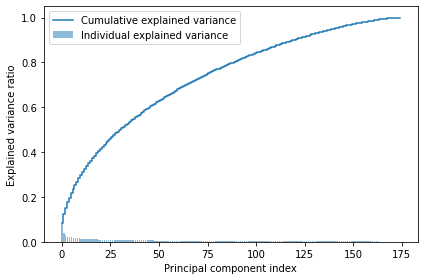

In [20]:
from sklearn.decomposition import PCA


#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
pca.fit(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

With only 25 components, we are able to greatly reduce the dimensionality of the data, while keeping half of the information.

In [21]:
pca = PCA(n_components=25, random_state=42).fit(X_train_std)

X_pca = pca.transform(X)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning:

X has feature names, but PCA was fitted without feature names



### Classification

We can now train our classifier and evaluate its performance.

#### Training

We train the classifier on the training set and make predictions on the train and test set.

In [22]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_jobs=-1).fit(X_train_pca, y_train)

y_train_pred = knn.predict(X_train_pca)
y_test_pred = knn.predict(X_test_pca)

#### Evaluation

We evaluate the classifier performance on the train and test set.

              precision    recall  f1-score   support

       drink       0.62      0.74      0.67       750
        food       0.74      0.77      0.75       750
    interior       0.59      0.66      0.62       750
        menu       0.90      0.75      0.82       750
     outside       0.76      0.61      0.67       750

    accuracy                           0.71      3750
   macro avg       0.72      0.71      0.71      3750
weighted avg       0.72      0.71      0.71      3750



/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



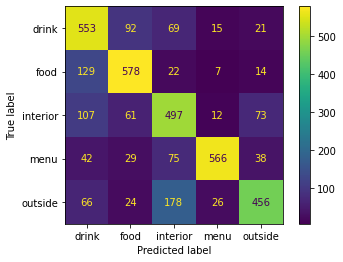

In [23]:
from sklearn.metrics import plot_confusion_matrix, classification_report


print(classification_report(y_train, y_train_pred))

plot_confusion_matrix(knn, X_train_pca, y_train)

              precision    recall  f1-score   support

       drink       0.47      0.57      0.52       250
        food       0.66      0.71      0.68       250
    interior       0.51      0.56      0.54       250
        menu       0.87      0.77      0.82       250
     outside       0.71      0.50      0.59       250

    accuracy                           0.62      1250
   macro avg       0.64      0.62      0.63      1250
weighted avg       0.64      0.62      0.63      1250



/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



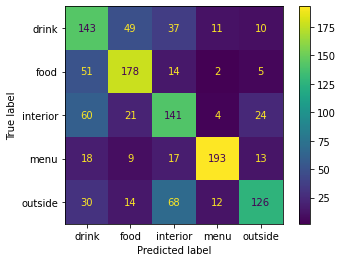

In [24]:
from sklearn.metrics import plot_confusion_matrix, classification_report


print(classification_report(y_test, y_test_pred))

plot_confusion_matrix(knn, X_test_pca, y_test)

We can see that the classifier is actually not too bad on the train set (F1 score ~ 0.73), but performs a bit worse on the test set (F1 score ~ 0.63).

We can see that our model performs very well on "menu" photos (especially on the test set), as well as "food" photos (especially on the train set).
But it performs poorly on "drink" and "interior" and "outside" photos.

#### Visualization


We can now visualize the prediction of the classifier on a random photo, with its nearest neighbor.

In [25]:
from sklearn.neighbors import NearestNeighbors


# Create a nearest neighbor classifier
nbrs = NearestNeighbors(n_neighbors=2).fit(X_pca)


# Compute the distances between the query image and all images
distances, indices = nbrs.kneighbors(X_pca)

1097
-------------------------------------------------------------------------
✅ Query prediction correct: food
Query image predicted labels:
   drink  food  interior  menu  outside
0    0.0   0.6       0.4   0.0      0.0
-------------------------------------------------------------------------
✅ Nearest image prediction correct: food
Nearest image predicted labels:
   drink  food  interior  menu  outside
0    0.0   0.6       0.2   0.0      0.2
-------------------------------------------------------------------------
✅ Query image and nearest image have same label: food
-------------------------------------------------------------------------


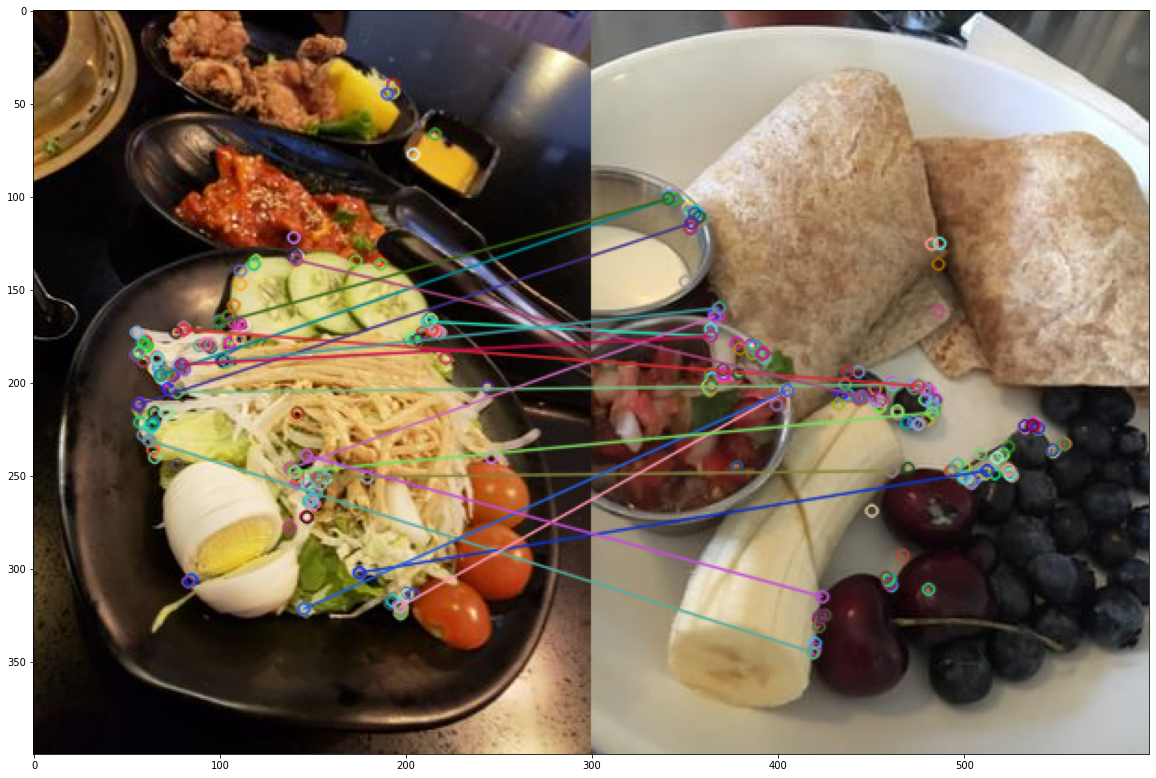

In [26]:
import random


query_index = random.randint(0, len(photos_features_df) - 1)
print(query_index)
nn_index = indices[query_index][1]

query_photo = photos_features_df.iloc[query_index]
query_img_path = os.path.join(
    "../data/raw/academic/photos", query_photo["file_name"] + ".jpg"
)
query_img = cv.cvtColor(
    cv.imread(query_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)
query_pred_proba = knn.predict_proba(X_pca[query_index].reshape(1, -1))
query_pred = knn.predict(X_pca[query_index].reshape(1, -1))[0]
query_true = y[query_index]

print("-------------------------------------------------------------------------")

if query_true == query_pred:
    print(f"✅ Query prediction correct: {query_pred}")
else:
    print(f"❌ Query prediction incorrect: {query_pred} (pred) vs. {query_true} (true)")

print(
    f"Query image predicted labels:\n{pd.DataFrame(query_pred_proba, columns=knn.classes_)}"
)

print("-------------------------------------------------------------------------")

nn_photo = photos_features_df.iloc[nn_index]
nn_img_path = os.path.join(
    "../data/raw/academic/photos", nn_photo["file_name"] + ".jpg"
)
nn_img = cv.cvtColor(cv.imread(nn_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)
nn_pred_proba = knn.predict_proba(X_pca[nn_index].reshape(1, -1))
nn_pred = knn.predict(X_pca[nn_index].reshape(1, -1))[0]
nn_true = y[nn_index]

if nn_true == nn_pred:
    print(f"✅ Nearest image prediction correct: {nn_pred}")
else:
    print(
        f"❌ Nearest image prediction incorrect: {nn_pred} (pred) vs. {nn_true} (true)"
    )

print(
    f"Nearest image predicted labels:\n{pd.DataFrame(nn_pred_proba, columns=knn.classes_)}"
)

print("-------------------------------------------------------------------------")

if query_true == nn_true:
    print(f"✅ Query image and nearest image have same label: {query_true}")
else:
    print(
        f"❌ Query image and nearest image have different labels: {query_true} (query) vs. {nn_true} (nearest)"
    )

print("-------------------------------------------------------------------------")

kp1 = photos_features_df.loc[query_index, "orb_keypoints"]
des1 = photos_features_df.loc[query_index, "orb_descriptors"]
kp2 = photos_features_df.loc[nn_index, "orb_keypoints"]
des2 = photos_features_df.loc[nn_index, "orb_descriptors"]


# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(
    query_img,
    kp1,
    nn_img,
    kp2,
    good,
    None,
    # flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
fig = plt.figure(figsize=(20, 15))
plt.imshow(img3)
plt.show()

## Image classification with a CNN

We are going to use a pre-trained CNN to label the photos.

### Basic photo labelling

First, we are going to test the photo labelling feature of the pre-trained CNN.

We are going to use VGG16 from Keras to extract the features of the photos and predict the best labels among the 1000 classes the model has learned.

In [27]:
photos_df["file_name"] = [x + ".jpg" for x in photos_df["photo_id"]]
photos_df

photo_id             business_id  \
32823   z6-4XQmfKuBuQ0GLVtJerA  LMpZdARWyOILtY_J2ZicyQ   
16298   5Sz1hsnhT8FYzdUzWw-yGA  qnI1XUK6AiLUduZAeoxAvQ   
28505   TtltNsdo0xkEOQrLMdGimQ  eMcTfefta-2T6KmNyDZs5A   
6689    hBpRETEuwmzwiQnbV9A14w  YhlJWNEmvviUAQSsKV-X9A   
26893   D5qbaIRKiY7UyehfE9428A  l6MDltWjrX39UzH_eZtVeQ   
...                        ...                     ...   
168897  BwC1iSOMe7Hc0tDW8PecYw  2ekSBeeosMbqJbihoqDfSg   
168957  mX41UiPjxPsdLGIG2CpjJA  nbG4q_Ki43HbJ-vfDCvipQ   
179003  OGQD3DaSnXp3V0Uqvo6rHw  kDZjCT0VllXTGnwCj__UXg   
186394  bjRvv-IkoIl4Y5Pp3N58cA  zt_Dy0aW6LLY_k2Uo-TxDw   
174545  26pBT0u4XFdhgUUCuX7Tqw  uNgTjA9ADe_6LWby20Af8g   

                                                  caption  label  \
32823                                                      drink   
16298                            Cheap+White+Delicious $7  drink   
28505                      How the water is served (Cute)  drink   
6689                                                       drink   
26893                                                      drink   
...                                                   ...    ...   
168897                                       Season menu!   menu   
168957  Current menu as of 1/31/21. Limited "due to CO...   menu   
179003                                                      menu   
186394                                            Tequila   menu   
174545                                      Cocktail menu   menu   

                         file_name  
32823   z6-4XQmfKuBuQ0GLVtJerA.jpg  
16298   5Sz1hsnhT8FYzdUzWw-yGA.jpg  
28505   TtltNsdo0xkEOQrLMdGimQ.jpg  
6689    hBpRETEuwmzwiQnbV9A14w.jpg  
26893   D5qbaIRKiY7UyehfE9428A.jpg  
...                            ...  
168897  BwC1iSOMe7Hc0tDW8PecYw.jpg  
168957  mX41UiPjxPsdLGIG2CpjJA.jpg  
179003  OGQD3DaSnXp3V0Uqvo6rHw.jpg  
186394  bjRvv-IkoIl4Y5Pp3N58cA.jpg  
174545  26pBT0u4XFdhgUUCuX7Tqw.jpg  

[5000 rows x 5 columns]

2021-12-13 09:52:48.916806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-13 09:52:48.916857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-13 09:52:52.732608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-13 09:52:52.732640: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-13 09:52:52.732667: I tensorflow/stream_executor/cuda/cuda_diagno

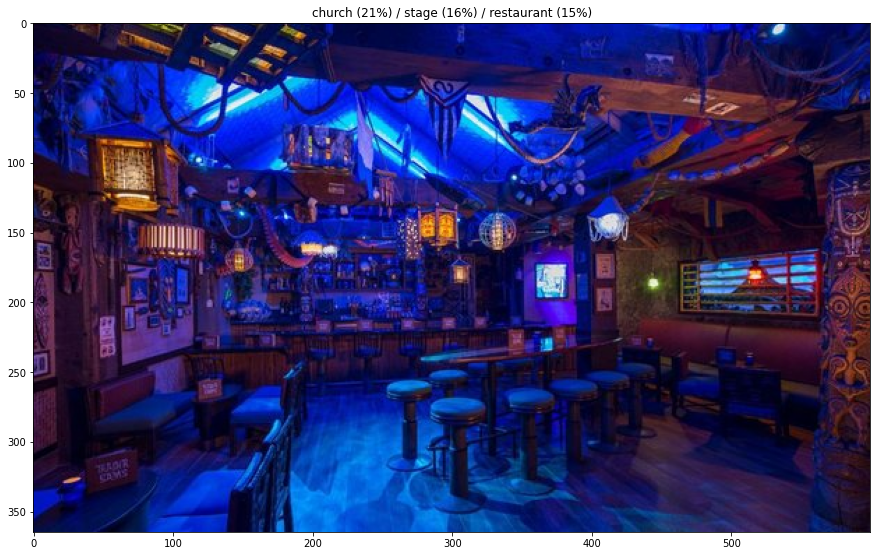

In [28]:
# Pick a random photo
photo = photos_df.sample().iloc[0]
img_path = os.path.join("../data/raw/academic/photos/", photo["file_name"])


from keras.applications.vgg16 import VGG16

model = VGG16()  # Création du modèle VGG-16 implementé par Keras

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img(img_path, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape(
    (1, img.shape[0], img.shape[1], img.shape[2])
)  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

pred = model.predict(
    img
)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)


from keras.applications.vgg16 import decode_predictions


predictions = decode_predictions(pred, top=3)[0]
query_img = cv.cvtColor(cv.imread(img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(query_img)
plt.title(
    f"{predictions[0][1]} ({round(100*predictions[0][2])}%) / {predictions[1][1]} ({round(100*predictions[1][2])}%) / {predictions[2][1]} ({round(100*predictions[2][2])}%)"
)
plt.show()

We can see that even without any work from our part, the model is very good at describing what the photo represents.

Now we want to use this model to predict our classes ("food", "drink, "menu", "interior" and "outside").

### Transfer learning

We want to reuse the pre-trained CNN to learn and predict the labels of our own photos. For that, we are going to implement the "feature extraction" part of the transfer learning.

#### Model definition

First, we need to define the model. We will use VGG16 as a base model, and we will add our own fully connected layers for the prediction of our labels.

In [29]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model


# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False

# Récupérer la sortie de ce réseau
x = vgg.output
x = Flatten()(x)

# Ajouter la nouvelle couche fully-connected pour la classification à 5 classes
predictions = Dense(5, activation="softmax")(x)

# Définir le nouveau modèle
model = Model(inputs=vgg.input, outputs=predictions)

# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Model evaluation

We can now fit and evaluate our model on the dataset.

In [30]:
from keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator


classes = ["drink", "food", "interior", "menu", "outside"]

if os.path.exists("../results/vgg16_academic.h5"):
    logger.info("Loading model from disk")
    model = load_model("../results/vgg16_academic.h5")
else:
    # Initiate the generator
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(
        dataframe=photos_df,
        directory="../data/raw/academic/photos/",
        x_col="file_name",
        y_col="label",
        target_size=(224, 224),
        classes=classes,
    )

    # Fit the model on the batches generated by datagen.flow()
    history = model.fit(generator)

    # Save model
    with open("../results/vgg16_academic.h5", "wb") as f:
        logger.info("Saving model to disk")
        model.save(f)

This model is much more powerful than the previous one. The accuracy is now at 0.9, and the F1 score is at 0.9.

In [31]:
y_cnn = photos_df["label"]
X_cnn = []
y_cnn_pred = []


if os.path.exists("../results/vgg16_academic_classification.csv"):
    logger.info("Loading classification results from disk")
    y_cnn_pred_df = pd.read_csv("../results/vgg16_academic_classification.csv")
    y_cnn_pred = y_cnn_pred_df["label_pred"]
else:
    for photo in photos_df.itertuples():
        img_path = os.path.join("../data/raw/academic/photos/", photo.file_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)

        X_cnn.append(img)

        pred = model.predict(img)
        y_cnn_pred.append(classes[pred.argmax()])

    # Save results
    with open("../results/vgg16_academic_classification.csv", "wb") as f:
        logger.info("Saving classification results to disk")
        y_cnn_pred_df = pd.DataFrame()
        y_cnn_pred_df["label_pred"] = [classes[x] for x in y_cnn_pred]
        y_cnn_pred_df.to_csv(f, index=False)

In [32]:
from sklearn.metrics import plot_confusion_matrix, classification_report


print(classification_report(y_cnn, y_cnn_pred))

              precision    recall  f1-score   support

       drink       1.00      0.87      0.93      1000
        food       0.92      0.99      0.95      1000
    interior       0.92      0.89      0.91      1000
        menu       0.98      0.99      0.98      1000
     outside       0.88      0.96      0.92      1000

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



We can see that the classification is excellent! It has been able to predict correctly almost all the classes of our dataset.

#### Visualization

At last, we can visualize the prediction of the model on a random photo.

✅ Prediction correct : menu


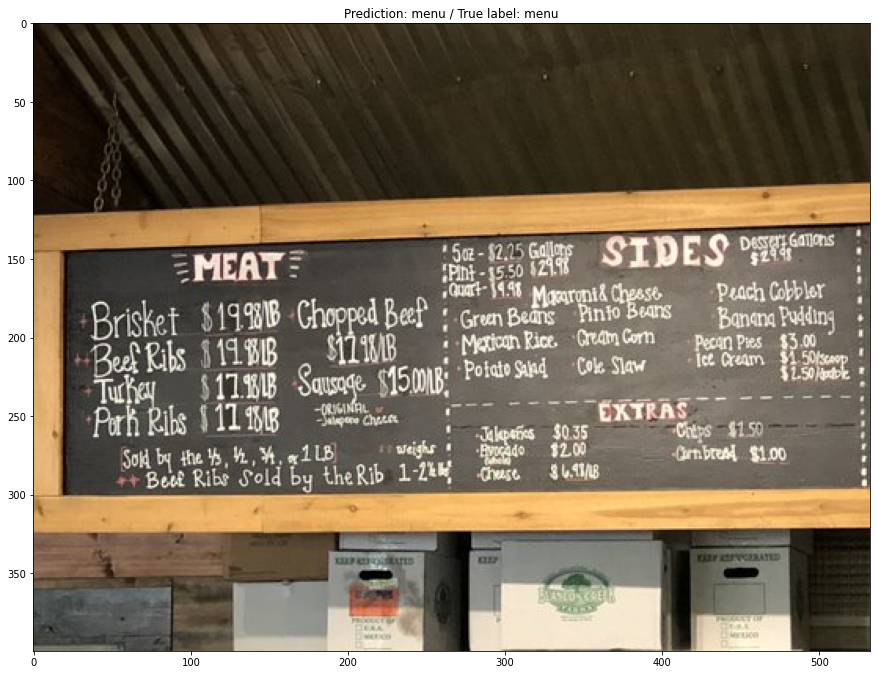

In [33]:
# Pick a random photo
photo = photos_df.sample().iloc[0]
img_path = os.path.join("../data/raw/academic/photos/", photo["file_name"])

img = load_img(img_path, target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape(
    (1, img.shape[0], img.shape[1], img.shape[2])
)  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

pred = model.predict(
    img
)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Plot image with prediction
from keras.applications.vgg16 import decode_predictions


query_img = cv.cvtColor(cv.imread(img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

if classes[pred.argmax()] == photo["label"]:
    print(f"✅ Prediction correct : {classes[pred.argmax()]}")
else:
    print(
        f"❌ Prediction incorrect : {classes[pred.argmax()]} (should be {photo['label']})"
    )

plt.figure(figsize=(15, 15))
plt.imshow(query_img)

plt.title(f"Prediction: {classes[pred.argmax()]} / True label: {photo['label']}")
plt.show()